# 0. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict

# Load preprocessed data from Part 1
df = pd.read_csv(
    '../processed_dataset.csv',
    engine='python',
    on_bad_lines='skip'
)


In [2]:
import ast

def safe_literal_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(x, list):
        return x
    else:
        return []
    

# we need to convert the string representation of lists/dicts back to actual lists/dicts
df['processed_text'] = df['processed_text'].apply(safe_literal_eval)
df['attributes'] = df['attributes'].apply(safe_literal_eval)

In [3]:
df.head()

,pid,url,processed_text,title,description,brand_facet,category_facet,subcategory_facet,seller_facet,discount,selling_price,actual_price,average_rating,attributes
0,TKPFCZ9EA7H5FYZH,https://www.flipkart.com/yorker-solid-men-mult...,"[solid, women, multicolor, track, pant, yorker...",Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,york,clothing_and_accessories,bottomwear,shyam_enterprises,69.0,921.0,2999.0,3.9,"[elast, side, pocket, cotton, blend, solid, mu..."
1,TKPFCZ9EJZV2UVRZ,https://www.flipkart.com/yorker-solid-men-blue...,"[solid, men, blue, track, pant, yorker, trackp...",Solid Men Blue Track Pants,Yorker trackpants made from 100% rich combed c...,york,clothing_and_accessories,bottomwear,shyam_enterprises,66.0,499.0,1499.0,3.9,"[drawstr, elast, side, pocket, cotton, blend, ..."
2,TKPFCZ9EHFCY5Z4Y,https://www.flipkart.com/yorker-solid-men-mult...,"[solid, men, multicolor, track, pant, yorker, ...",Solid Men Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,york,clothing_and_accessories,bottomwear,shyam_enterprises,68.0,931.0,2999.0,3.9,"[elast, side, pocket, cotton, blend, solid, mu..."
3,TKPFCZ9ESZZ7YWEF,https://www.flipkart.com/yorker-solid-men-mult...,"[solid, women, multicolor, track, pant, yorker...",Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,york,clothing_and_accessories,bottomwear,shyam_enterprises,69.0,911.0,2999.0,3.9,"[elast, side, pocket, cotton, blend, solid, mu..."
4,TKPFCZ9EVXKBSUD7,https://www.flipkart.com/yorker-solid-men-brow...,"[solid, women, brown, gray, track, pant, yorke...","Solid Women Brown, Grey Track Pants",Yorker trackpants made from 100% rich combed c...,york,clothing_and_accessories,bottomwear,shyam_enterprises,68.0,943.0,2999.0,3.9,"[drawstr, elast, side, pocket, cotton, blend, ..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pid                28080 non-null  object 
 1   url                28080 non-null  object 
 2   processed_text     28080 non-null  object 
 3   title              28080 non-null  object 
 4   description        16927 non-null  object 
 5   brand_facet        26071 non-null  object 
 6   category_facet     28080 non-null  object 
 7   subcategory_facet  28080 non-null  object 
 8   seller_facet       26437 non-null  object 
 9   discount           27225 non-null  float64
 10  selling_price      28078 non-null  float64
 11  actual_price       27303 non-null  float64
 12  average_rating     25819 non-null  float64
 13  attributes         28080 non-null  object 
dtypes: float64(4), object(10)
memory usage: 3.0+ MB


First, we should analyze the missing values of the variables and define how to handle them
- since we did not do this in part 1, and some description entries are null, we need to ensure that this 'none' or 'nan' values are not added to processed_text
- textual/categorical --> we fill with unkown since it keeps it searchable and consisten
- numerical fields --> we fill them with 0 (we should interpret as 0 discount or no average rating available) 

In [5]:
# Fill missing textual/categorical values
text_cols = ['description', 'brand_facet',
             'seller_facet']
df[text_cols] = df[text_cols].fillna('unknown') #replace any missing text with 'unknown' 

# Fill missing numerical fields with 0
num_cols = ['discount', 'selling_price', 'actual_price', 'average_rating']
df[num_cols] = df[num_cols].fillna(0) #replace any missing number with '0'

# Ensure 'attributes' column has lists, even when missing
df['attributes'] = df['attributes'].apply(lambda x: x if isinstance(x, list) else [])

# Verify
print("Missing values after cleaning:")
print(df.isna().sum())


Missing values after cleaning:
pid                  0
url                  0
processed_text       0
title                0
description          0
brand_facet          0
category_facet       0
subcategory_facet    0
seller_facet         0
discount             0
selling_price        0
actual_price         0
average_rating       0
attributes           0
dtype: int64


In [6]:
has_none = df['processed_text'].apply(lambda tokens: 'none' in tokens or 'nan' in tokens)
print("Number of affected rows:", has_none.sum())

def clean_tokens(tokens): #remove placeholder tokens 
    if isinstance(tokens, list):
        return [t for t in tokens if t not in ['none', 'nan']]
    return tokens

df['processed_text'] = df['processed_text'].apply(clean_tokens) #merge the two lists of tokens

Number of affected rows: 3


# 1.1. Inverted Index

In [7]:
# we need all the tokens in a single column for the inverted index, hence we concatenate the processed_text and attributes columns
df['tokens'] = df['processed_text'] + df['attributes']

Now we are building the inverted index: 
- Inverted index maps each word (token) to the documents (products) that contain it. 

In [8]:
def build_inverted_index(df):
    """
    Build an inverted index mapping each token to a set of document IDs (pids)
    that contain that token.
    """
    inverted_index = defaultdict(set)
    
    for i, row in df.iterrows():
        for token in row['tokens']:
            inverted_index[token].add(row['pid'])
    
    # Convert sets to sorted lists for readability
    inverted_index = {term: sorted(list(docs)) for term, docs in inverted_index.items()}
    return inverted_index

inverted_index = build_inverted_index(df)
print(f"Inverted index built with {len(inverted_index)} unique terms.")


Inverted index built with 5692 unique terms.


In [9]:
for i, (term, postings) in enumerate(inverted_index.items()):
    print(f"{term}: {postings[:5]}")  # show first 5 product IDs for each term
    if i == 9:  # stop after 10 terms
        break

solid: ['4hWtdShnw%3D%3D', 'BDAFYGRSSHGHBBYE', 'BRFEWB5RPBDW9DKP', 'BRFEX35MBHYTBYGC', 'BRFEZEF49JAWFCMD']
women: ['ARME8P6GZGFHAUPX', 'BDAFSFMYKJDGSXUG', 'BDAFT7NGPTHYGVRJ', 'BDAFT8JHVBQ6ZT3F', 'BDAFT8JQFNVHGBVH']
multicolor: ['ARME8P6GFSXGE9AW', 'ARME8P6GJQ8PZBE6', 'ARME8P6GXFED7RJZ', 'ARME8P6GZGFHAUPX', 'BDAFSFMYKJDGSXUG']
track: ['BXRFGGX685HKER8Y', 'BXRFGYQTPZNHEWFD', 'BXRFGYQUTHXJKHHP', 'BXRFGYQUZH5DCABH', 'BXRFGYRYGUURZGDG']
pant: ['BXRFGGX685HKER8Y', 'BXRFGYQTPZNHEWFD', 'BXRFGYQUTHXJKHHP', 'BXRFGYQUZH5DCABH', 'BXRFGYRYGUURZGDG']
yorker: ['TKPFCZ9DYU33FFXS', 'TKPFCZ9E2UC3DR3F', 'TKPFCZ9EA7H5FYZH', 'TKPFCZ9ECDYYDNKA', 'TKPFCZ9EFK9DNWDA']
trackpant: ['CRGFGQRNCB7QVEME', 'CRGFGQS63JKJZM34', 'TKPEFVQAPRHKVJHJ', 'TKPEFVQB8Z65YCYQ', 'TKPEFVQBA9FJA8WX']
rich: ['CRGFB6UNUPXTTY7F', 'CRGFDCWNCYTB8SAM', 'CTPFVZD8CNSZ3AMR', 'CTPFVZEYHCRQ27Y2', 'CTPFVZFYR8KGYYBJ']
comb: ['BRFEWB5RPBDW9DKP', 'BRFEX35MBHYTBYGC', 'BRFEZEF49JAWFCMD', 'BRFEZWU9FCHYPJDU', 'BRFFYNFYDDNAUDZZ']
cotton: ['4hWtdShnw%3D

Our index contains 5692 unique terms, that means that our dataset contained 5692 distinct words. 

In [10]:
# we save the inverted index to a json file in order to use it later 
with open('inverted_index.json', 'w') as f:
    json.dump(inverted_index, f)

# 1.2.Test queries

Now, to evaluate our search engine, we'll need to define 5 queries. To choose them, we'll look at the exploratory data analysis that we did in part1 and we'll use popular terms of our dataframe.

In [11]:
#We use some of the most common terms to build the queries. We include some brand name, category name, washing instructions etc.
five_query_list = ["blue shirt round neck machine wash", "solid men blue trackpants", "full sleeve casual shirt cotton", "women polo t-shirt", "white shirt cotton"]

Let's preprocess the example queries in the same way we did for our dataframe. We built different preprocessing functions, but we'll use the natural text one. 

In [12]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

def setup_preprocessing_tools():
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    stop_words.update(['made', 'wear', 'comfort', 'quality', 
                       'look', 'perfect', 'style', 'great', 'cool'])
    stop_words.discard('no')
    stop_words.discard('not')
    return stemmer, stop_words

In [13]:
import re
import string
from nltk.tokenize import word_tokenize
def preprocess_query(text, stemmer, stop_words):
    """
    Preprocess natural text:
    - lowercase
    - remove punctuation/numbers
    - tokenize
    - remove stopwords and non-alphabetic tokens
    - stem 
    """
    if not isinstance(text, str):
        return []
    
    text = text.replace('-', ' ')

    # lowercase
    text = text.lower()

    # remove punctuation and digits
    text = re.sub(f"[{re.escape(string.punctuation)}0-9]", " ", text)

    # tokenize
    tokens = word_tokenize(text)

    # filter tokens (stopwords, non-alpha, short tokens)
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]

    # stem
    tokens = [stemmer.stem(w) for w in tokens]

    # normalize color terms 
    color_map = {'navy': 'blue', 'grey': 'gray', 'fucsia': 'pink', 'burgundy': 'red', 'violet': 'purple', 'beige': 'brown', 'magenta': 'pink', 'indigo': 'blue', 
                 'charcoal': 'gray', 'crimson': 'red', 'teal': 'green', 'lavender': 'purple', 'mustard': 'yellow', 'turquoise': 'blue', 'peach': 'orange'}

    tokens = [color_map.get(w, w) for w in tokens]

    return tokens

# 1.3. TF-IDF and Ranking

Let's implement TF-IDF now.

In [14]:
# Calculate Document Frequency (DF) for each term
df_scores = {term: len(postings) for term, postings in inverted_index.items()}

#Example DF scores for some terms
print(f"DF for 'solid': {df_scores.get('solid')}")
print(f"DF for 'pant': {df_scores.get('pant')}")

DF for 'solid': 11997
DF for 'pant': 2069


In [15]:
# The total number of documents (N)
N = len(df)

# Calculate IDF scores
idf_scores = {term: np.log(N / df_val) for term, df_val in df_scores.items()} #Don't need to handle log(0) since df_val is always >=1 because it's calculated from the inverted index's postings lists
#Example IDF scores for some terms
print(f"IDF for 'solid': {idf_scores.get('solid')}")
print(f"IDF for 'pant': {idf_scores.get('pant')}")

IDF for 'solid': 0.8504009606248194
IDF for 'pant': 2.6079921803942043


In [16]:
# Save IDF scores so we can reuse them later without recalculating
with open('idf_scores.json', 'w') as f:
    json.dump(idf_scores, f)

In [17]:
from collections import Counter

def calculate_log_tf(tokens):
    """Calculates log-normalized TF for each term in a document's token list."""
    counts = Counter(tokens)
    return {term: 1 + np.log(count) for term, count in counts.items()} #Don't need to handle log(0) since count is always >=1 because it's only done for terms that appear in tokens

# Apply this function to every document's tokens
df['tf_scores'] = df['tokens'].apply(calculate_log_tf)

# Check the TF scores for the first document
print("TF scores for first document:")
print(df.iloc[0]['tf_scores'])

TF scores for first document:
{'solid': np.float64(1.6931471805599454), 'women': np.float64(1.0), 'multicolor': np.float64(1.6931471805599454), 'track': np.float64(1.0), 'pant': np.float64(1.0), 'yorker': np.float64(1.0), 'trackpant': np.float64(1.0), 'rich': np.float64(1.6931471805599454), 'comb': np.float64(1.0), 'cotton': np.float64(1.6931471805599454), 'give': np.float64(1.0), 'design': np.float64(1.0), 'skin': np.float64(1.0), 'friendli': np.float64(1.0), 'fabric': np.float64(1.0), 'itch': np.float64(1.0), 'free': np.float64(1.0), 'waistband': np.float64(1.0), 'year': np.float64(1.0), 'round': np.float64(1.0), 'use': np.float64(1.0), 'proudli': np.float64(1.0), 'india': np.float64(1.0), 'elast': np.float64(1.0), 'side': np.float64(1.0), 'pocket': np.float64(1.0), 'blend': np.float64(1.0)}


Now we compute the TF-IDF and L2 norm.

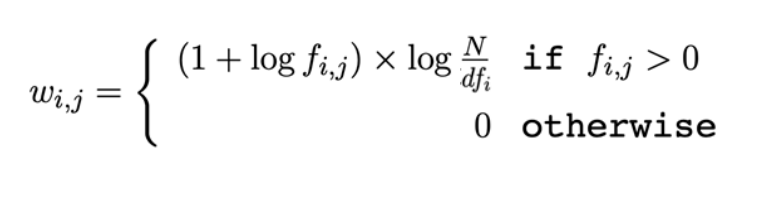

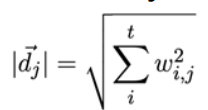

In [18]:
def calculate_tfidf_L2_norm(tf_scores, idf_scores_global):
    """
    Calculates the TF-IDF vector (as a dict) and the L2-norm (length)
    of that vector for a single document.
    """
    tfidf_vector = {}
    sum_of_squares = 0.0
    
    for term, tf in tf_scores.items():
        # Only include terms that are in our global IDF dictionary
        if term in idf_scores_global:
            tfidf = tf * idf_scores_global[term]
            tfidf_vector[term] = tfidf
            sum_of_squares += tfidf**2
            
    doc_length = np.sqrt(sum_of_squares)
    return tfidf_vector, doc_length

# Apply the function to the 'tf_scores' column
# This returns a tuple (tfidf_vector, doc_length), so we split it into two new columns
tfidf_results = df['tf_scores'].apply(lambda tf: calculate_tfidf_L2_norm(tf, idf_scores))
df['tfidf_vector'] = tfidf_results.apply(lambda x: x[0])
df['doc_length'] = tfidf_results.apply(lambda x: x[1])

# Check the results for the first document
print("TF-IDF vector for first document:")
print(df.iloc[0]['tfidf_vector'])
print("\nDocument length for first document:")
print(df.iloc[0]['doc_length'])

TF-IDF vector for first document:
{'solid': np.float64(1.439853988827382), 'women': np.float64(0.7098818692235951), 'multicolor': np.float64(2.979595529588283), 'track': np.float64(2.738972111440796), 'pant': np.float64(2.6079921803942043), 'yorker': np.float64(7.107318642210598), 'trackpant': np.float64(4.362279871739047), 'rich': np.float64(7.193930820733286), 'comb': np.float64(4.251348311031766), 'cotton': np.float64(0.5814838578355617), 'give': np.float64(2.490477694837456), 'design': np.float64(1.6255933526563855), 'skin': np.float64(2.881437429162399), 'friendli': np.float64(4.449799249755603), 'fabric': np.float64(1.5888186252313647), 'itch': np.float64(6.115678473094656), 'free': np.float64(3.341075651483173), 'waistband': np.float64(3.9586786970689456), 'year': np.float64(3.9775116454020374), 'round': np.float64(1.07841171810501), 'use': np.float64(2.216642663193321), 'proudli': np.float64(4.446755107374376), 'india': np.float64(0.8549122464713206), 'elast': np.float64(2.9045

Now that we built TF-IDF algorithm, we can implement the ranking function.

In [19]:
stemmer, stop_words = setup_preprocessing_tools()
df_indexed = df.set_index('pid')

def search_tfidf(query_text, inverted_index, idf_scores, df_docs, k=10):
    """
    Performs a ranked TF-IDF search for a given query.
    
    Args:
        query_text (str): The raw query string.
        inverted_index (dict): The inverted index.
        idf_scores (dict): The pre-calculated IDF scores for all terms.
        df_docs (pd.DataFrame): The DataFrame (indexed by 'pid') 
                                containing 'tfidf_vector' and 'doc_length'.
        k (int): The number of top results to return.

    Returns:
        list: A list of (pid, score) tuples, sorted by score.
    """
    
    # Preprocess the query
    query_tokens = preprocess_query(query_text, stemmer, stop_words)
    
    # Find matching documents (Conjunctive/AND query)
    try:
        # Retrieve the set of pids for each query token
        doc_sets = [set(inverted_index[token]) for token in query_tokens if token in inverted_index]
        
        # If any token is not in the index, no docs will match an AND query
        if len(doc_sets) != len(query_tokens):
            print("One or more query terms not in index. No results.")
            return []

        # Find the intersection of all sets
        matching_pids = set.intersection(*doc_sets)
    
    except KeyError:
        # This handles if a token isn't in the index, though the check above is safer
        print("Query term not in index. No results.")
        return []

    if not matching_pids:
        print("No documents contain all query terms.")
        return []

    # Calculate the Query TF-IDF Vector and its length
    query_tf = calculate_log_tf(query_tokens)
    query_tfidf_vector = {}
    query_sum_of_squares = 0.0
    
    for term, tf in query_tf.items():
        if term in idf_scores:
            tfidf = tf * idf_scores[term]
            query_tfidf_vector[term] = tfidf
            query_sum_of_squares += tfidf**2
            
    query_length = np.sqrt(query_sum_of_squares)
    
    if query_length == 0:
        print("Query vector has no length (all terms unknown).")
        return []

    # Calculate Cosine Similarity for all matching documents
    scores = {}
    
    # Filter the main DataFrame to only the documents that matched
    # .loc is fast because we set the index to 'pid'
    matching_docs = df_docs.loc[list(matching_pids)]
    
    for pid, row in matching_docs.iterrows():
        doc_tfidf_vector = row['tfidf_vector']
        doc_length = row['doc_length']
        
        # Calculate Dot Product
        dot_product = 0.0
        # Iterate over the query vector, which is much smaller
        for term, query_tfidf_val in query_tfidf_vector.items():
            if term in doc_tfidf_vector:
                dot_product += query_tfidf_val * doc_tfidf_vector[term]
        
        # Calculate Cosine Similarity
        if doc_length > 0:
            scores[pid] = dot_product / (query_length * doc_length)
    
    # Sort and return the top K results
    sorted_results = sorted(scores.items(), key=lambda item: item[1], reverse=True)
    
    final_results = []
    # Loop through the top k sorted (pid, score) tuples
    for pid, score in sorted_results[:k]:
        
        # Get the product data
        product_data = df_docs.loc[pid]
        
        # Append a dictionary with all the info you want
        final_results.append({
            'title': product_data['title'],
            'score': score,
            'pid': pid,
            'url': product_data['url'],
            'selling_price': product_data['selling_price'],
            'brand': product_data['brand_facet']
        })
        
    return final_results

In [20]:
#Test ranking function with the test queries
for i in range(len(five_query_list)):
    print(f"\n=======================================================")
    print(f"RESULTS FOR QUERY {i+1}: '{five_query_list[i]}'")
    print(f"=======================================================")
    
    detailed_results = search_tfidf(
        five_query_list[i], 
        inverted_index, 
        idf_scores, 
        df_indexed, 
        k=10
    )
    
    if detailed_results:
        for rank, item in enumerate(detailed_results, 1):
            print(
                f"  Rank {rank}: PID: {item['pid']}\n"
                f"     Score: {item['score']:.4f}\n"
                f"     Title: {item['title']}\n"
                f"     Brand: {item['brand']}\n"
            )
    else:
        print("  No results found for this query.")


RESULTS FOR QUERY 1: 'blue shirt round neck machine wash'
  Rank 1: PID: TSHFXHAPHNFGX68Q
     Score: 0.7132
     Title: Printed Men Round Neck Blue T-Shirt
     Brand: rose_we

  Rank 2: PID: TSHFVSS3Q8GGG3XG
     Score: 0.7048
     Title: Printed Men Round Neck Blue T-Shirt
     Brand: xi

  Rank 3: PID: TSHFN6QANCZHVQZB
     Score: 0.6934
     Title: Solid Men Round Neck Blue T-Shirt
     Brand: axma

  Rank 4: PID: TSHFN6QAHTJ523ZR
     Score: 0.6927
     Title: Solid Men Round Neck Blue T-Shirt
     Brand: axma

  Rank 5: PID: TSHFZ8TQWHDHKVNH
     Score: 0.6916
     Title: Printed Men Round Neck Blue T-Shirt
     Brand: yellowvib

  Rank 6: PID: TSHFW38SWDW6RDFW
     Score: 0.6860
     Title: Printed Women Round Neck Blue T-Shirt
     Brand: xi

  Rank 7: PID: TSHFVW4PHAGM5APR
     Score: 0.6849
     Title: Printed Men Round Neck Blue T-Shirt
     Brand: xi

  Rank 8: PID: TSHFW38SZDGGGKZH
     Score: 0.6849
     Title: Printed Men Round Neck Blue T-Shirt
     Brand: xi

  Rank 

In [21]:
#we are using AND strategy --> doc must contain all query tokens to be returned as match 
#main limitation of the and retrieval (very strict) 

# 2.1. Evaluation start, metrics functions

Metrics function, following the same strategy and format as in the lab from class: 

In [27]:
import numpy as np

# i. Precision@K (P@K)
def precision_at_k(y_true, y_score, k=10):
    """
    y_true : array-like, ground truth (1 = relevant, 0 = not relevant)
    y_score : array-like, predicted relevance scores
    k : int, number of top documents to consider
    """
    # sort indices by predicted score (descending)
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    # number of relevant docs in top-k
    relevant = np.sum(y_true)
    return relevant / k if k > 0 else 0.0


# ii. Recall@K (R@K)
def recall_at_k(y_true, y_score, k=10):
    """
    Fraction of all relevant documents retrieved in top-K.
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    total_relevant = np.sum(y_true) + np.sum(np.take(y_true, order[k:]))  # all positives
    total_relevant = np.sum(y_true) if total_relevant == 0 else np.sum(y_true)
    
    # we actually need total relevant in the whole dataset, not just top-k
    total_relevant = np.sum(y_true)
    if total_relevant == 0:
        return 0.0
    
    return np.sum(y_true) / total_relevant


# iii. Average Precision@K (P@K)
def avg_precision_at_k(y_true, y_score, k=10):
    """
    Approximates the area under the precision-recall curve.
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)
    num_relevant = 0
    precisions = []

    for i in range(min(k, len(y_true))):
        if y_true[i] == 1:
            num_relevant += 1
            precisions.append(num_relevant / (i + 1))

    if num_relevant == 0:
        return 0.0
    return np.mean(precisions)


# iv. F1-Score@K
def f1_at_k(y_true, y_score, k=10):
    """
    Harmonic mean of Precision@K and Recall@K.
    """
    p = precision_at_k(y_true, y_score, k)
    r = recall_at_k(y_true, y_score, k)
    return (2 * p * r) / (p + r) if (p + r) > 0 else 0.0


# v. Mean Average Precision (MAP)
def map_at_k(search_res, k=10):
    """
    search_res : pandas.DataFrame, must contain columns: ['query_id', 'y_true', 'y_score']
    """
    ap_scores = []
    for q in search_res['query_id'].unique():
        curr_data = search_res[search_res['query_id'] == q]
        ap = avg_precision_at_k(curr_data['y_true'].to_numpy(),
                                curr_data['y_score'].to_numpy(),
                                k)
        ap_scores.append(ap)
    return np.mean(ap_scores) if ap_scores else 0.0


# vi. Mean Reciprocal Rank (MRR)
def rr_at_k(y_true, y_score, k=10):
    """
    Returns the inverse of the rank of the first relevant document.
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    if np.sum(y_true) == 0:
        return 0.0
    first_rel = np.argmax(y_true)
    return 1 / (first_rel + 1)


def mrr_at_k(search_res, k=10):
    """
    Mean Reciprocal Rank@K across all queries.
    """
    rr_scores = []
    for q in search_res['query_id'].unique():
        curr_data = search_res[search_res['query_id'] == q]
        rr = rr_at_k(curr_data['y_true'].to_numpy(),
                     curr_data['y_score'].to_numpy(),
                     k)
        rr_scores.append(rr)
    return np.mean(rr_scores) if rr_scores else 0.0


# vii. Normalized Discounted Cumulative Gain (NDCG)
def dcg_at_k(y_true, y_score, k=10):
    """Discounted Cumulative Gain@K"""
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, len(y_true) + 2))
    return np.sum(gains / discounts)


def ndcg_at_k(y_true, y_score, k=10):
    """Normalized DCG@K"""
    dcg_max = dcg_at_k(sorted(y_true, reverse=True), y_true, k)
    if dcg_max == 0:
        return 0.0
    return dcg_at_k(y_true, y_score, k) / dcg_max


# 2.2 Metrics for validation_labels.csv

Apply the evaluation metrics you have implemented to the search results and relevance
judgments provided in validation_labels.csv for the predefined queries. When reporting
evaluation results, provide only numeric values, rounded to three decimal places. Do
not include textual explanations or additional statistics in this section.


In [25]:

import pandas as pd
relevance_df = pd.read_csv(r'C:\Users\User\OneDrive\Desktop\RIAW\irwa_search_engine_G_011\data\validation_labels.csv')
print(relevance_df.head())

                                        title               pid  query_id  \
0        Full Sleeve Printed Women Sweatshirt  SWSFFVKBCQG5FHPF         1   
1        Full Sleeve Striped Women Sweatshirt  SWSFJY5ZFHQ7HXKW         1   
2        Full Sleeve Printed Women Sweatshirt  SWSFUY89NHMZHZPX         1   
3  Full Sleeve Graphic Print Women Sweatshirt  SWSFXQ5YX6RZKHP4         1   
4          Full Sleeve Solid Women Sweatshirt  JCKFTZBC3DMCVYXH         1   

   labels  
0       1  
1       0  
2       1  
3       1  
4       0  


# 2.3. Analysis of current system, manually research

Evaluation for our 5 custom queries (Part1)
For the test queries you defined in Part 1, Step 2 during indexing, assign a binary relevance label to each document: 1 if the document is relevant to the query, or 0 if it is not. 

In [ ]:

k = 10
evaluation_results = []

for i, query in enumerate(five_query_list, start=1):
    print(f"\n=======================================================")
    print(f"Evaluating QUERY {i}: '{query}'")
    print(f"=======================================================")
    
    # Results obtained feore from our list 
    results = detailed_results
    
    y_score = [r['score'] for r in results]
    
    # We manually define ground truth (1 = relevant, 0 = not relevant)
    # Based on the titles/brands we printed before, we decided if each result is relevant or not 
    
    if i == 1:
        y_true = [1,1,1,1,1,1,1,1,1,1]  
    elif i == 2:
        y_true = [1,1,1,1,1,1,1,1,1,0]

    elif i == 3:
        y_true = [1,1,1,1,1,0,0,0,0,0]

    elif i == 4:
        y_true = [1,1,1,1,1,1,1,1,1,1]

    elif i == 5:
        y_true = [1,1,1,1,1,1,1,1,1,1]

    
    # We compute metrics
    p = precision_at_k(y_true, y_score, k)
    r = recall_at_k(y_true, y_score, k)
    ap = avg_precision_at_k(y_true, y_score, k)
    f1 = f1_at_k(y_true, y_score, k)
    rr = rr_at_k(y_true, y_score, k)
    ndcg = ndcg_at_k(y_true, y_score, k)
    
    # Then save the results 
    evaluation_results.append({
        "Query": query,
        "P@10": round(p, 3),
        "R@10": round(r, 3),
        "AP@10": round(ap, 3),
        "F1@10": round(f1, 3),
        "RR@10": round(rr, 3),
        "NDCG@10": round(ndcg, 3)
    })

# Convert to DataFrame for readability
eval_5ql_df = pd.DataFrame(evaluation_results)
print("\n===== Evaluation Results =====")
print(eval_5ql_df)



Evaluating QUERY 1: 'blue shirt round neck machine wash'

Evaluating QUERY 2: 'solid men blue trackpants'

Evaluating QUERY 3: 'full sleeve casual shirt cotton'

Evaluating QUERY 4: 'women polo t-shirt'

Evaluating QUERY 5: 'white shirt cotton'

===== Evaluation Results =====
                                Query  P@10  R@10  AP@10  F1@10  RR@10  \
0  blue shirt round neck machine wash   1.0   1.0  1.000  1.000    1.0   
1           solid men blue trackpants   0.9   1.0  0.977  0.947    1.0   
2     full sleeve casual shirt cotton   0.5   1.0  1.000  0.667    1.0   
3                  women polo t-shirt   1.0   1.0  1.000  1.000    1.0   
4                  white shirt cotton   1.0   1.0  1.000  1.000    1.0   

   NDCG@10  
0    1.000  
1    0.994  
2    1.000  
3    1.000  
4    1.000  
